In [1]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import datetime,timedelta
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
end_date = datetime.now()
stock_symbol = "GOOGL"
# Format the current date as "year-month-date"
# formatted_date = cend_date.strftime('%Y-%m-%d')
start_date = "2015-01-01"
end_date  = end_date.strftime('%Y-%m-%d')

In [3]:
df = yf.download(stock_symbol ,period='5y',interval='1d')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-24,57.970501,59.259499,57.575001,58.978001,58.978001,31150000
2018-09-25,59.212502,59.842999,58.704498,59.694500,59.694500,33152000
2018-09-26,59.684502,60.362000,59.270000,59.702999,59.702999,37650000
2018-09-27,60.000000,60.842999,59.902500,60.368000,60.368000,36274000
2018-09-28,60.204498,60.422501,59.891499,60.354000,60.354000,35612000
...,...,...,...,...,...,...
2023-09-18,136.610001,139.160004,136.610001,138.210007,138.210007,21861300
2023-09-19,137.419998,138.410004,136.619995,138.039993,138.039993,20353700
2023-09-20,138.080002,138.080002,133.619995,133.740005,133.740005,29927500


In [4]:
# df.reset_index(inplace=True)
# df = df[['Date', 'Close']]

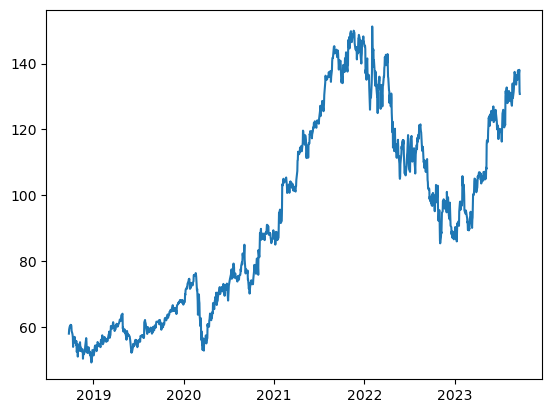

In [5]:
plt.plot(df.index, df['Open'])

In [6]:
ds = df["Open"].values

In [7]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [8]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [9]:
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [10]:
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [11]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [12]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [13]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


2023-09-24 10:24:47.948716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-24 10:24:47.949469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-24 10:24:47.950675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [14]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100


2023-09-24 10:24:48.167959: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-24 10:24:48.276498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-24 10:24:48.277126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-24 10:24:48.277593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

12/13 [==========================>...] - ETA: 0s - loss: 0.0579

2023-09-24 10:24:51.202653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-24 10:24:51.203402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-24 10:24:51.203858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 3s 128ms/step - loss: 0.0574 - val_loss: 0.0218
Epoch 2/100
13/13 [==============================] - 1s 89ms/step - loss: 0.0097 - val_loss: 0.0050
Epoch 3/100
13/13 [==============================] - 1s 91ms/step - loss: 0.0029 - val_loss: 0.0056
Epoch 4/100
13/13 [==============================] - 1s 92ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 5/100
13/13 [==============================] - 1s 93ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 6/100
13/13 [==============================] - 1s 93ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 7/100
13/13 [==============================] - 1s 92ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 8/100
13/13 [==============================] - 1s 95ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 9/100
13/13 [==============================] - 1s 96ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 10/100
13/13 [==============================] - 1s 96ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 11/1

Epoch 81/100
13/13 [==============================] - 1s 108ms/step - loss: 7.8214e-04 - val_loss: 0.0016
Epoch 82/100
13/13 [==============================] - 1s 108ms/step - loss: 7.4535e-04 - val_loss: 0.0017
Epoch 83/100
13/13 [==============================] - 1s 105ms/step - loss: 7.4422e-04 - val_loss: 0.0014
Epoch 84/100
13/13 [==============================] - 1s 104ms/step - loss: 7.6442e-04 - val_loss: 0.0014
Epoch 85/100
13/13 [==============================] - 1s 105ms/step - loss: 7.9622e-04 - val_loss: 0.0015
Epoch 86/100
13/13 [==============================] - 1s 101ms/step - loss: 8.1372e-04 - val_loss: 0.0019
Epoch 87/100
13/13 [==============================] - 1s 105ms/step - loss: 7.5472e-04 - val_loss: 0.0015
Epoch 88/100
13/13 [==============================] - 1s 107ms/step - loss: 7.0575e-04 - val_loss: 0.0019
Epoch 89/100
13/13 [==============================] - 1s 109ms/step - loss: 7.5384e-04 - val_loss: 0.0014
Epoch 90/100
13/13 [==========================

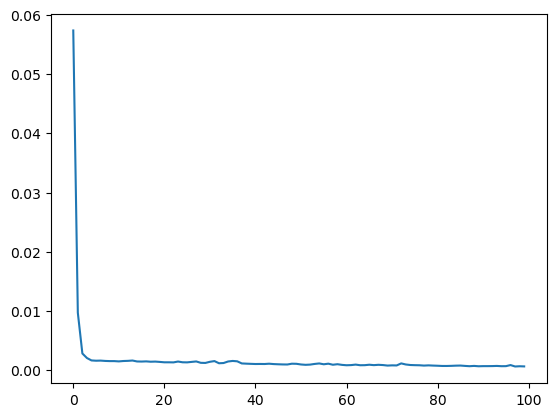

In [15]:
loss = model.history.history['loss']
plt.plot(loss)

In [16]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2023-09-24 10:27:00.889451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-24 10:27:00.890333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-24 10:27:00.891248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 0s 14ms/step


In [17]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

In [18]:
# #Comparing using visuals
# plt.plot(normalizer.inverse_transform(ds_scaled))
# plt.plot(train_predict)
# plt.plot(test_predict)

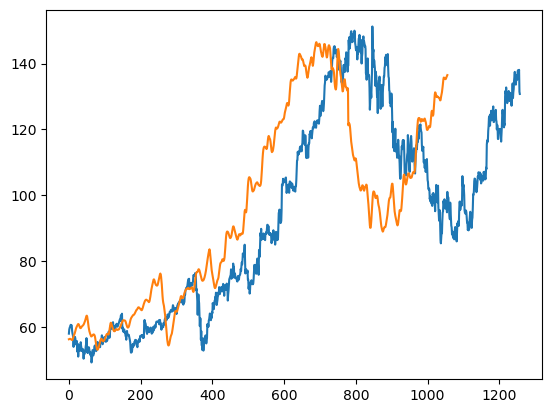

In [27]:
test = np.vstack((train_predict,test_predict))
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [28]:
fut_inp = ds_test[270:]
fut_inp = fut_inp.reshape(1,-1)
tmp_inp = list(fut_inp)
tmp_inp = tmp_inp[0].tolist()

In [31]:
fut_inp.shape

(1, 108)

In [35]:
lst_output=[]
n_steps=fut_inp.shape[1]
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.839142918586731], [0.8318183422088623], [0.8276474475860596], [0.8256668448448181], [0.8250489830970764], [0.825275182723999], [0.8260570764541626], [0.8272358775138855], [0.8287116289138794], [0.8304084539413452], [0.832260012626648], [0.8342037796974182], [0.8361830115318298], [0.8381454944610596], [0.8400471806526184], [0.8418508172035217], [0.8435279726982117], [0.8450573682785034], [0.8464260697364807], [0.8476279973983765], [0.8486629724502563], [0.8495371341705322], [0.850260317325592], [0.850846529006958], [0.8513117432594299], [0.8516736626625061], [0.8519509434700012], [0.8521621823310852], [0.8523248434066772], [0.8524556159973145]]


In [48]:
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)
# plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1132:]))
# plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [44]:
ds_new = ds_scaled.tolist()

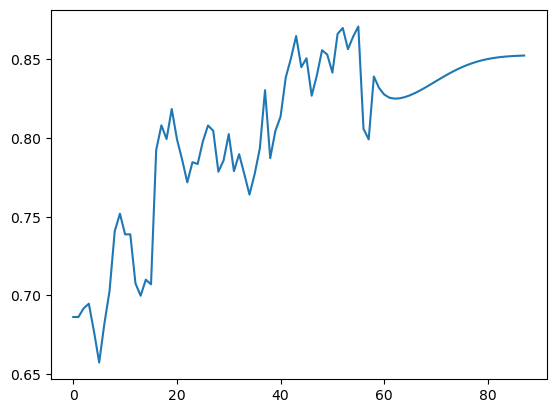

In [45]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [46]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

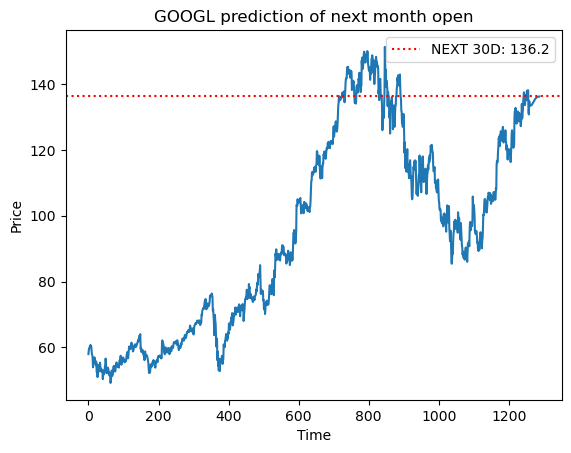

In [41]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()